# ML Experiment Tracking

In short, ML experiment tracking is a process of keeping track of relevant information:

* Parameters: hyperparameters (and data path)
* Artifacts: models and visualization
* Metrics
* Metadata: source code and environment

It is just [a part of MLOps process](https://neptune.ai/blog/ml-experiment-tracking) helping in efficiently building an ML model. It also provides three aspects to our development which are **reproducibility**, **optimization** and **organization**.

There are several tools and framework for managing ML lifecycle such as [MLflow](https://mlflow.org/), [Weight and Biases](https://wandb.ai/site) and [Comet ML](https://www.comet.com/site/). In this tutorial we'll focus on *MLflow* but you can find practical tutorial on [*Weight and Biases*](../cohorts/2023/02-experiment-tracking/wandb.md) and adapt to your needs as well.

*MLflow* has four main modules as the following:

* Tracking: tracks experiments and their results
* Project: packages and shares data science code
* Models: standardize model format and deployment
* Registry: model management and model versioning

For ML experiment tracking, we mostly use only the *Tracking* module in the package.

Note that *MLflow* provides only a rough framework because it is only the Python library. The standard concepts that are used among tools:

* ML experiment: the process of building an ML model
* Experiment run: each trial in an ML experiment
* Run artifact: any file that is associated with an experiment run
* Experiment metadata: related information about an ML experiment

In practice, we need also need a workflow (a framework) in order to even smooth the process. There are interesting framework to choose from. The recommended one is [Databricks MLOps Workflow](https://docs.databricks.com/en/machine-learning/mlops/mlops-workflow.html).

## Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import mlflow
import pickle
from functools import partial
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import root_mean_squared_error
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll import scope
from xgboost import XGBRegressor

In [3]:
# Helper functions
def preprocessing(raw_df, to_str_columns):
    """
    Preprocessing data before model training.
    - Create target.
    - Filter only a trip happened within an hour at most.
    - Cast to specific columns into "string" data type.
    """
    df = raw_df.copy()

    df["trip_duration"] = (df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]).apply(lambda x: x.total_seconds() / 60)
    df = df[(df["trip_duration"] >= 1) & (df["trip_duration"] <= 60)].copy()
    df[to_str_columns] = df[to_str_columns].astype(str)

    return df


def build_features(df):
    """
    Build synthetic features.
    - RouteID: PULocationID x DOLocationID
    """
    feature_df = df.copy()
    feature_df["RouteID"] = feature_df["PULocationID"] + '_' + feature_df["DOLocationID"]

    return feature_df


def feature_engineering(df, categorical_features, numerical_features, target, v=None):
    """
    Feature engineering.
    - One-hot encoding
    - Generate X and y
    """
    data = df[categorical_features + numerical_features].to_dict(orient="records")

    if v is None:
        v = DictVectorizer()
        X = v.fit_transform(data)
    else:
        X = v.transform(data)
    
    y = df[target].values

    return v, X, y

In [4]:
# MLflow setup
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("test-nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1717130592608, experiment_id='1', last_update_time=1717130592608, lifecycle_stage='active', name='test-nyc-taxi-experiment', tags={}>

Note that *MLflow* needs a place to store every relevant information from an experiment run. Therefore, we need to set what called a "tracking server". You can also do that on a local machine via `mlflow.set_tracking_uri("http://127.0.0.1:5000")`.

## Basic Experiment Run

In order to add *MLflow* to the ML model development process, we need to add `with mlflow.start_run() as run:` snippet of code as a part of ML experiment tracking and you can start logging every information you find useful later on in the model debugging process.

In [5]:
# Set predictors and target
categorical_features = ["RouteID"]
numerical_features = ["trip_distance"]

target = "trip_duration"

### Model Training

In [6]:
# Data preprocessing
training_data = "../01-intro/data/green_tripdata_2021-01.parquet"
raw_train_df = pd.read_parquet(training_data)

train_df = preprocessing(raw_train_df, to_str_columns=["PULocationID", "DOLocationID"])
train_df = build_features(train_df)

v, X_train, y_train = feature_engineering(train_df, categorical_features, numerical_features, target)
print(f"Feature vector: {X_train.shape}")
print(f"Output vector: {y_train.shape}")

Feature vector: (73908, 13221)
Output vector: (73908,)


In [55]:
# Model training
alpha = 0.001
l1_ratio = 0.95

regr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
regr.fit(X_train, y_train)

ElasticNet(alpha=0.001, l1_ratio=0.95, random_state=42)

### Model Evaluation

In [56]:
# Data preprocessing
validation_data = "../01-intro/data/green_tripdata_2021-02.parquet"
raw_validation_df = pd.read_parquet(validation_data)

validation_df = preprocessing(raw_validation_df, to_str_columns=["PULocationID", "DOLocationID"])
validation_df = build_features(validation_df)

_, X_val, y_val = feature_engineering(validation_df, categorical_features, numerical_features, target, v=v)
print(f"Feature vector: {X_val.shape}")
print(f"Output vector: {y_val.shape}")

Feature vector: (61921, 13221)
Output vector: (61921,)


RMSE on validation dataset: 9.42


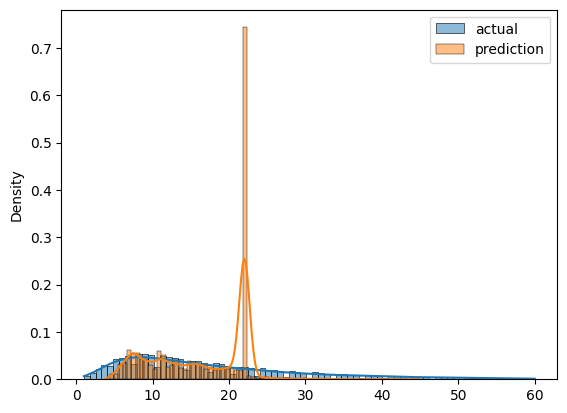

In [57]:
# Model evaluation
y_pred = regr.predict(X_val)

rmse = root_mean_squared_error(y_val, y_pred)
print(f"RMSE on validation dataset: {rmse:.2f}")

trip_duration_dist, _ = plt.subplots() # For storing as a Figure object
sns.histplot(y_val, label="actual", kde=True, stat="density")
sns.histplot(y_pred, label="prediction", kde=True, stat="density")

plt.legend()
# plt.savefig("trip-duration-distribution.png")
plt.show()

### Model Persistence

In [58]:
with open("models/basic-eln.pkl", "wb") as f:
    pickle.dump((v, regr), f)

### ML Experiment Tracking

In [59]:
with mlflow.start_run() as run:
    
    # For searching purpose
    mlflow.set_tag("developer", "nkgreenk")
    mlflow.set_tag("model_type", "baseline")

    # Data versioning logging as a data path
    mlflow.log_param("training_data", training_data)
    mlflow.log_param("validation_data", validation_data)

    # Log hyperparameters
    mlflow.log_params({"alpha": alpha, "l1_ratio": l1_ratio})
    
    # Log metric(s)
    mlflow.log_metric("rmse", rmse)

    # Log visualization
    mlflow.log_figure(trip_duration_dist, "visualization/trip-duration-distribution.png")
    
    # Log model by referring to a local object
    mlflow.log_artifact(local_path="models/basic-eln.pkl", artifact_path="pickle-models")

Note that you can also wrap model training, model evaluation and model persistence processes in the ML experiment tracking part. By doing so, it allows us to know the time duration of each run, which in my opinion, it is also an important metric to our ML model development.

However, by separating each section into process, it helps developer to clearly see and understand the process better. Therefore, it is up to the team's preference which one to choose from.

For basic experiment run, it may be useful when logging a baseline or simple model. Next, we'll see how we can use *MLflow* together with hyperparameter optimization framework like *Hyperopt* or *Optuna* to automatically log each hyperparameter in each run and use them to compare and debug our model.

## Experiment Run with Hyperparameter Tuning

Basically, in *Scikit-Learn*, it has the general methods for every ML algorithm to do hyperparameter optimization, Both of them are `GridSearchCV` and `RandomizedSearchCV`. They can provides a good results but the main disadvantage is it has to do exhausive search on the given parameters (For `RandomizedSearchCV` is the same but with the smaller search space).

As a result, a new approach called **Bayesian Optimization** suggest the way to maintain the performance (or even improve it) and lower a large amount of computation cost and time.

Bayesian optimization makes use of the past evaluation to build a probability model of the objective function so called a **surrogate model** and uses it to select hyperparameters using what called an **acquisition function** to evaluate in the true objective function iteratively. The process is described as the following:

1. First, randomly initiate a surrogate model and an acquisition function.
2. For each iteration, find the new hyperparameters where the acquisition function is optimized.
3. Calculate the objective function score of the new hyperparameters.
4. Update the surrogate model with hyperparameters-objective-function-score pair of example.

Note that an acquisition function is a function of a surrogate model. For the full detail explaination to bayesian optimization:

* [Bayesian Optimization Concept Explained in Layman Terms](https://towardsdatascience.com/bayesian-optimization-concept-explained-in-layman-terms-1d2bcdeaf12f)
* [Step-by-Step Guide to Bayesian Optimization: A Python-based Approach](https://medium.com/@okanyenigun/step-by-step-guide-to-bayesian-optimization-a-python-based-approach-3558985c6818)

Now, let's dive into code. First, you need to define a `search_space`. For getting the best model for tabular data, we are likely to use ensemble model like boosting or bagging. In this case, we'll use *XGBoost* model.

### Search Space for Hyperparameter Tuning

Instead of defining hyperparameters discretely like doing via `GridSearchCV` or `RandomizedSearchCV`, for *XGBoost*, there are a lot of hyperparameters we can tune.

Note that we'll not use `early_stopping_rounds` for this although it is very common in practice. The reason is that `n_estimators` is the parameter that we are about to tune in the process.

If you want to set `early_stopping_rounds` to empirically find the opimal `n_estimators` instead, in order to completely make use of every samples in your dataset, you need to split data on `train_df` for evaluating in the model building process. Next, you need to fit the model on the whole `train_df` before going to the next processes like hyperparamer tuning or model selection using `best_iteration` attribute. Note that you can also make use of cross validation to fully use all of your dataset. 

This is unique for *XGBoost* only as in the algorithms which their training processes are similar such as MLPs, they also have the number of `epoch` but it is impossible to update weight in MLPs again with the whole dataset. If you doing so, it is called **re-training** or **fine-tuning** process.

In [7]:
search_space = {
    "n_estimators": scope.int(hp.quniform("n_estimators", 100, 1000, 50)), 
    # "max_depth": scope.int(hp.quniform("max_depth", 4, 100, 1)), 
    "learning_rate": hp.loguniform("learning_rate", -3, 0), 
    # "reg_alpha": hp.loguniform("reg_alpha", -5, -1), 
    # "reg_lambda": hp.loguniform("reg_lambda", -6, -1), 
    # "min_child_weight": hp.loguniform("min_child_weight", -1, 3), 
    "objective": "reg:squarederror", 
    "random_state": 42, 
    "n_jobs": -1
}

### Objective Function for Hyperparameter Tuning

Next, you need to define an `objective` function.

Note that in order to use *MLflow* with *Hyperopt*, we need to wrap ML experiment tracking part into the `objective` function. This is because the optimizer needs to search for the best set of hyperparameters internally in each iteration. If we want to log each iteration as an experiment run, we need to start an experiment on each optimization iteration.

In [8]:
def objective(params, x, y, cv):
    """
    Objective function for an ML model to optimize.
    """
    with mlflow.start_run():

        mlflow.set_tags({"developer": "nkgreenk", "model": "xgboost"})

        mlflow.log_param("training_data", training_data)
        mlflow.log_param("validation_data", validation_data)

        mlflow.log_params(params)
        regr = XGBRegressor(**params) 

        scores = cross_val_score(regr, x, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1)
        rmse = -1.0 * sum(scores) / len(scores)
        mlflow.log_metric("rmse", rmse)

    return {"loss": rmse, "status": STATUS_OK}

In [9]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
optimizer = partial(objective, x=X_train, y=y_train, cv=kfold)

best_result = fmin(
    fn=optimizer, 
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=50, 
    trials=Trials()
)

100%|██████████| 50/50 [33:35<00:00, 40.32s/trial, best loss: 5.605208137898129]


In [14]:
best_result.update({"objective": "reg:squarederror", "random_state": 42, "n_jobs": -1})
best_result["n_estimators"] = int(best_result["n_estimators"])

Note that in practice, it is essential to pay attention to the dataset you use to validate on a specific process in order to prevent **data leakage**. In this case, "VALIDATION" set is for model selection process.

Therefore, we'll use cross validation on `train_df` to selectively choose hyperparameters before model selection.

### Fit with Best Hyperparameters

Last, we'll use the best parameter we get from the previous process to evaluate with `validation_df` in the model selection. To do so, we'll fit the model with the best hyperparameters and the whole set of `train_df`. This time we'll log relevant information along with the training process.

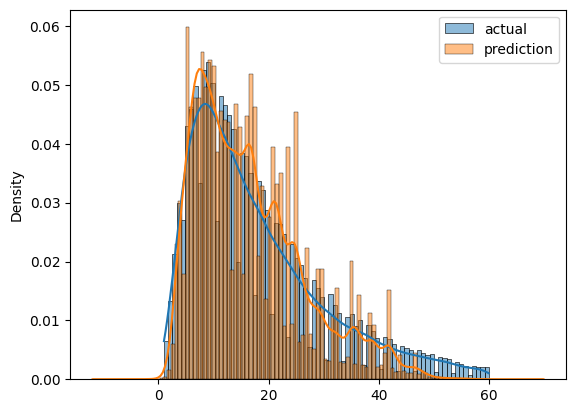

/home/codespace/miniconda3/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:21:17] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [49]:
with mlflow.start_run() as run:
    
    mlflow.set_tags({"developer": "nkgreenk", "model": "xgboost"})
    
    mlflow.log_param("training_data", training_data)
    mlflow.log_param("validation_data", validation_data)

    # Log hyperparameters
    mlflow.log_params(best_result)

    # Log metric(s)
    regr = XGBRegressor(**best_result)
    regr.fit(X_train, y_train)

    y_pred = regr.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    # Log visualization
    trip_duration_dist, _ = plt.subplots() # For storing as a Figure object
    sns.histplot(y_val, label="actual", kde=True, stat="density")
    sns.histplot(y_pred, label="prediction", kde=True, stat="density")

    plt.legend()
    plt.show()

    mlflow.log_figure(trip_duration_dist, "visualization/xgboost-trip-duration-distribution.png")

    # Log preprocessor for data preprocessing
    with open("models/preprocessor.pkl", "wb") as f:
        pickle.dump(v, f)
    
    mlflow.log_artifact(local_path="models/preprocessor.pkl", artifact_path="preprocessor")
    
    # Log model for prediction
    mlflow.xgboost.log_model(regr, artifact_path="mlflow-models")

We can also use `mlflow.xgboost.autolog()` to simplify code above. This function will log all basic parameters including model and environment. However, it may not log all the relevant information needed by the users. You may need to log them yourself.

Moreover, if you use a `Pipeline` object in `sklearn.pipeline`, you can log a whole pipeline as a `sklearn` or `xgboost` model. This makes a model not just predict a result but can do data preprocessing before making an inference, which als benefits us in terms of ease in model management.

Note that there is another library called *Optuna* that you can used. From the [Optuna VS Hyperopt](https://neptune.ai/blog/optuna-vs-hyperopt), *Optuna* seems to be a slightly better choice. However, if your focus is on getting the best set of hyperparameters only, *Hyperopt* can provide the same outcome.

For hands-on coding on hyperparameters with various libraries used, checkout [Hyperparameter Optimization: This Tutorial is All You Need](https://www.youtube.com/watch?v=5nYqK-HaoKY).

### Inference

In experiment tracking, we've already log model using `mlflow.xgboost.log_model`. This will add the `MLmodel` file which add flavour to our model. Flavour will help you as an ML engineer to be able to choose which format to deploy the model. For *XGBoost*, you can select to make an inference based on the *MLflow* format or using an *XGBoost* object.

Note that if you use `mlflow.log_artifact` instead, it will log the model as a file and *MLflow* won't create other metadata files automatically.

In [13]:
# Download inference data
!wget -O data/green_tripdata_2021-03.parquet https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-03.parquet

--2024-06-02 04:20:13--  https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-03.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 18.161.3.119, 18.161.3.209, 18.161.3.141, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|18.161.3.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1474538 (1.4M) [binary/octet-stream]
Saving to: ‘data/green_tripdata_2021-03.parquet’

data/green_tripdata 100%[===================>]   1.41M  1.50MB/s    in 0.9s    

2024-06-02 04:20:15 (1.50 MB/s) - ‘data/green_tripdata_2021-03.parquet’ saved [1474538/1474538]



In [21]:
# Data preprocessing
test_data = "data/green_tripdata_2021-03.parquet"
raw_test_df = pd.read_parquet(test_data)

test_df = preprocessing(raw_test_df, to_str_columns=["PULocationID", "DOLocationID"])
test_df = build_features(test_df)

with open("models/preprocessor.pkl", "rb") as f:
    preprocessor = pickle.load(f)

_, X_test, y_test = feature_engineering(test_df, categorical_features, numerical_features, target, v=preprocessor)
print(f"Feature vector: {X_test.shape}")
print(f"Output vector: {y_test.shape}")

Feature vector: (80372, 13221)
Output vector: (80372,)


In [24]:
# Model inference
modelfile = "runs:/86d2f73e0ca544538bdebc644f5b2397/mlflow-models"

loaded_model = mlflow.pyfunc.load_model(modelfile) # MLflow model
y_pred = loaded_model.predict(X_test)

# loaded_model = mlflow.xgboost.load_model(modelfile) # XGBoost model
# y_pred = loaded_model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
print(f"RMSE on validation dataset: {rmse:.2f}")

RMSE on validation dataset: 6.32


MLflow model and XGBoost model should yield the same results.

Note that the difference between artifacts and models is *MLflow* has a specific API for models. It allows you to load and use the model directly from the tracking server. Whereas, for artifacts, you need to download or use them locally to make an inference.